In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from pysindy.utils import linear_damped_SHO
from pysindy.utils import cubic_damped_SHO
from pysindy.utils import linear_3D
from pysindy.utils import hopf
from pysindy.utils import lorenz

import pysindy as ps

import sys; sys.path.append('../')
from best_subset import *
from UBIC import *
from okridge.tree import BNBTree
from okridge.solvel0 import *
from sklearn.utils.random import sample_without_replacement

from scipy.stats import wilcoxon, ranksums, mannwhitneyu, friedmanchisquare
from para_UBIC import find_corner
from skscope_tools import best_subset_solution, abess_solution, best_subset_all_solutions, abess_all_solutions

from scipy.signal import savgol_filter

np.random.seed(1000)

Sklearn's version: 1.5.2


### Data

In [2]:
# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

name = 'lorenz'; target = 2

# Linear 2D ODE
if name == 'linear2d':
    dt = 0.01
    t_train = np.arange(0, 25, dt)
    t_train_span = (t_train[0], t_train[-1])
    x0_train = [2, 0]
    x_train = solve_ivp(linear_damped_SHO, t_train_span, 
                        x0_train, t_eval=t_train, **integrator_keywords).y.T
    true_complexities = [2, 2]

# Cubic 2D ODE
elif name == 'cubic2d':
    dt = 0.01
    t_train = np.arange(0, 25, dt)
    t_train_span = (t_train[0], t_train[-1])
    x0_train = [2, 0]
    x_train = solve_ivp(cubic_damped_SHO, t_train_span, 
                        x0_train, t_eval=t_train, **integrator_keywords).y.T
    true_complexities = [2, 2]

# Linear 3D ODE
elif name == 'linear3d':
    dt = .01
    t_train = np.arange(0, 50, dt)
    t_train_span = (t_train[0], t_train[-1])
    x0_train = [2, 0, 1]
    x_train = solve_ivp(linear_3D, t_train_span, 
                        x0_train, t_eval=t_train, **integrator_keywords).y.T
    true_complexities = [2, 2, 1]

# Lorenz (3D)
elif name == 'lorenz':
    dt = 0.001
    t_train = np.arange(0, 100, dt)
    t_train_span = (t_train[0], t_train[-1])
    x0_train = [-8, 8, 27]
    x_train = solve_ivp(lorenz, t_train_span, 
                        x0_train, t_eval=t_train, **integrator_keywords).y.T
    x_dot_train_measured = np.array(
        [lorenz(0, x_train[i]) for i in range(t_train.size)]
    )
    true_complexities = [2, 3, 2]

In [3]:
noise_level = 1e-2
x_train_clean = x_train.copy()
if noise_level != 0:
    x_train = x_train_clean + np.random.normal(scale=noise_level, size=x_train.shape)

In [4]:
x_train = savgol_filter(x_train, 11, 3, axis=0)

In [5]:
# TODO: Implement ps.differentiation.Kalman(alpha=...)
poly_order = 4
if name == 'linear3d': poly_order = 3
threshold = 1e-4
differentiation_method = ps.differentiation.FiniteDifference()
differentiation_method = ps.differentiation.SmoothedFiniteDifference()

### Modeling

In [6]:
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    differentiation_method=differentiation_method, 
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt); model.print()

model = ps.SINDy(
    # optimizer=ps.STLSQ(threshold=threshold),
    optimizer=ps.SR3(reg_weight_lam=0.001, relax_coeff_nu=1), 
    differentiation_method=differentiation_method, 
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt); model.print()

# x_sim = model.simulate(x_train[0], t_train)
# bic = 0
# for i in range(x_sim.shape[-1]):
#     bic += BIC_AIC(x_sim[:, i:i+1], x_train[:, i:i+1], 
#                    np.count_nonzero(model.coefficients()[i]))[0]
# bic /= x_sim.shape[-1]
# bic

(x0)' = 0.001 1 + -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -0.001 1 + -2.667 x2 + 1.000 x0 x1
(x0)' = -10.059 x0 + 10.032 x1
(x1)' = -0.091 1 + 27.862 x0 + -0.940 x1 + -0.990 x0 x2
(x2)' = -2.665 x2 + 0.993 x0 x1


In [7]:
# model = ps.SINDy(
#     # optimizer=L0BNB(max_nonzeros=3, lam=1e-3, is_normal=True, normalize_columns=False), 
#     # optimizer=BruteForceRegressor(support_size=true_complexities), 
#     optimizer=ps.STLSQ(threshold=threshold), 
#     feature_library=ps.PolynomialLibrary(degree=2), 
# )

# model.fit(x_train, t=dt)
# model.print()

# x_sim = model.simulate(x_train[0], t_train)
# bic = 0
# for i in range(x_sim.shape[-1]):
#     bic += BIC_AIC(x_sim[:, i:i+1], x_train[:, i:i+1], 
#                    np.count_nonzero(model.coefficients()[i]))[0]
# bic /= x_sim.shape[-1]
# bic

In [8]:
X_pre, y_pre, feature_names = ps_features(x_train, t_train, 
                                          ps.PolynomialLibrary(degree=poly_order, include_bias=True), 
                                          differentiation_method=differentiation_method, 
                                          center_output=False, expand_dims=False)
y_pre = y_pre[:, target-1:target]

In [9]:
# TODO: Apply MIOSR here... / Ensemble of optimizers? to get the best subsets
k = 8 # cardinality constraint
lambda2 = 1e-5 # l2 regularization parameter
gap_tol = 1e-6 # optimality gap tolerance
try:
    coefficients, best_subsets = okridge_solvel0_full(X_pre, y_pre, k, lambda2, gap_tol)
except AttributeError:
    coefficients, best_subsets = best_subset_all_solutions(X_pre[:, 1:], y_pre, k, refine=True)
    # coefficients, best_subsets = abess_all_solutions(X_pre[:, 1:], y_pre, k, refine=True)

 25%|███████████████                                             | 2/8 [00:00<00:01,  4.27it/s]/Users/pongpisit/anaconda3/envs/pysr_latest/lib/python3.11/site-packages/okridge/node.py:269: LinAlgWarning: Ill-conditioned matrix (rcond=1.10762e-16): result may not be accurate.
  self.lower_beta_on_allowed_support = scipy.linalg.solve(
 38%|██████████████████████▌                                     | 3/8 [00:00<00:01,  3.60it/s]/Users/pongpisit/anaconda3/envs/pysr_latest/lib/python3.11/site-packages/okridge/node.py:269: LinAlgWarning: Ill-conditioned matrix (rcond=1.10762e-16): result may not be accurate.
  self.lower_beta_on_allowed_support = scipy.linalg.solve(
 50%|██████████████████████████████                              | 4/8 [00:01<00:01,  3.32it/s]/Users/pongpisit/anaconda3/envs/pysr_latest/lib/python3.11/site-packages/okridge/node.py:269: LinAlgWarning: Ill-conditioned matrix (rcond=1.10762e-16): result may not be accurate.
  self.lower_beta_on_allowed_support = scipy.linalg.so

In [10]:
sindy_valid_indices = []
for bs in best_subsets:
    # coef = ps.STLSQ(alpha=lambda2, threshold=threshold).fit(X_pre[:, bs], y_pre).coef_
    coef = ps.SR3(reg_weight_lam=0.001, relax_coeff_nu=1).fit(X_pre[:, bs], y_pre).coef_
    print(np.count_nonzero(coef), coef)
    sindy_valid_indices.append(max(np.count_nonzero(coef)-1, 0))
sindy_valid_indices = np.array(sorted(set(sindy_valid_indices)))
sindy_valid_indices

0 [[-0.]]
2 [[25.54574273 -0.95133896]]
3 [[27.99759622 -0.99954205 -0.99993353]]
3 [[27.9986386  -1.00029955 -0.99996454  0.        ]]
3 [[27.99287548 -0.99959685 -0.99933781 -0.          0.        ]]
3 [[27.99762474 -0.99955838  0.         -0.99993432 -0.          0.        ]]
3 [[27.99582096 -1.00094564 -0.99934187  0.         -0.         -0.
   0.        ]]
3 [[28.0128402  -1.00835095 -1.00050724  0.          0.         -0.
   0.          0.        ]]


array([0, 1, 2])

### Selection
    - Implement varying BICs + stats test

In [11]:
_, base_bic, _ = baye_uncertainties(best_subsets, (X_pre, y_pre), 
                                    u_type='cv1', take_sqrt=True, threshold=0)
varying_bics = []
for _ in range(30):
    indices = sample_without_replacement(len(X_pre), len(X_pre)//5)
    _, varying_bic, _ = baye_uncertainties(best_subsets, (X_pre[indices, :], y_pre[indices]), 
                                           u_type='cv1', take_sqrt=True, threshold=0, ridge_lambda=0)
    varying_bics.append(varying_bic)
varying_bics = np.array(varying_bics).T

In [12]:
pv_threshold = 0.01
valid_indices = decreasing_values_indices(base_bic)
for i in range(len(valid_indices)-1, 0, -1):
    R = valid_indices[i]
    L = np.argmin(base_bic[:valid_indices[i]])
    pv = mannwhitneyu(varying_bics[R], varying_bics[L], 
                      alternative='less').pvalue
    if not pv < pv_threshold:
        valid_indices = np.delete(valid_indices, [i])
    else:
        print(pv)
valid_indices

1.5099296795810785e-11
1.5099296795810785e-11


array([0, 1, 2])

In [13]:
def conditional_argmin(ics, valid_indices=None):
    if valid_indices is None:
        return np.argmin(ics)
    else:
        assert len(valid_indices) > 0
        assert len(set(valid_indices)-set(np.arange(len(ics)))) == 0
        return max(valid_indices[np.where(valid_indices<=np.argmin(ics))[0]])
# valid_indices = None
valid_indices = np.array(sorted(set(valid_indices).intersection(set(sindy_valid_indices))))
track = {}

tau = 3
verbose = True
scale = np.log(len(y_pre)) 
# scale = 1 <- generalized UBIC
per = 75 # 90

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), 
                                               u_type='cv1', take_sqrt=True, 
                                               threshold=0)
predictions = X_pre@post_means
print(b_bics)
b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
try:
    thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
except IndexError:
    thres = 0.01
min_thres = 0.01
thres = max(thres, min_thres)
# thres = 0.02
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = conditional_argmin(last_ubic, valid_indices)
track[np.argmin(last_ubic)] = last_lam

while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = conditional_argmin(now_ubic, valid_indices)
    track[np.argmin(last_ubic)] = last_lam
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = np.nan
    if diff_com != 0:
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    assert last_bc == best_bc
    
last_lam = abs(round(last_lam, 8))
last_lam, last_ubic, last_bc, best_bc

[1025238.8809873501, 516451.9434561249, 336315.04145626863, 336326.5278323557, 336337.9270332737, 336349.345697824, 336360.7350200222, 336372.06642667344]
threshold: 0.45939563946000195
max_lam: 4.63336419987523
2 <---> 2 inf
2 <---> 2 inf
2 <---> 2 inf


(0.0,
 array([1025398.43213544,  516463.95577877,  336326.55438173,
         336353.32200789,  336372.4472072 ,  336361.94536801,
         336405.76491309,  336451.23262095]),
 2,
 2)

3 3 3
[[29], [1, 6], [1, 2, 6], [1, 2, 6, 8], [1, 2, 6, 15, 29], [1, 2, 5, 6, 14, 28], [1, 2, 6, 10, 11, 15, 29], [1, 2, 6, 8, 10, 11, 13, 24]]


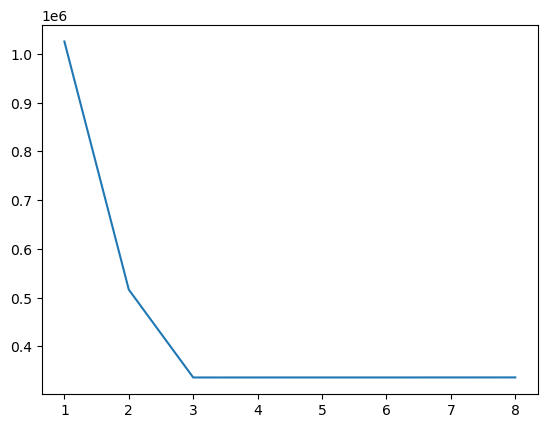

In [14]:
alt_best_bc = list(track.keys())[np.argmin(abs(np.array(list(track.keys())) - best_bc))]
if min(best_bc, alt_best_bc) == best_bc:
    ubic_plot = last_ubic
    lam_plot = last_lam
else:
    lam_plot = track[alt_best_bc]
    ubic_plot = UBIC(b_bics, b_uns, len(y_pre), hyp=10**lam_plot, scale=scale)

corner_ubic_complexity = find_corner(complexities, ubic_plot)
corner_bic_complexity = find_corner(complexities, b_bics)
print(corner_bic_complexity, best_bc+1, corner_ubic_complexity)
print(best_subsets)

plt.plot(complexities, ubic_plot)
plt.xticks(complexities)
plt.show()

In [15]:
(np.argsort(ubic_plot)+1)

array([3, 4, 6, 5, 7, 8, 2, 1])